# Cutout of images

To work and test faster, it can be useful to work with cutouts of images instead of the full images. This notebook allows to create cutouts of many images at the same time, even with different pixel scales (as long as they have a valid WCS).

In [1]:
import os
from typing import Union
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, MinMaxInterval, ZScaleInterval, LogStretch
from astropy.visualization.wcsaxes import add_scalebar
import astropy.units as u

## Simple cutout

First, let's make a cutout on a single image to choose framing (`center` and `size`).

In [2]:
def add_good_scalebar(ax, wcs, color='white', fraction=0.25, corner='bottom right', pad=0.1):
    """
    Utility function for astropy.visualization.wcsaxes.add_scalebar
    to automaticaly resize the scalebar to the size of the image.

    ax : matplotlib.pyplot.Axes where to draw the scale bar
    wcs : WCS of the image
    color : color of the scale bar
    fraction : fraction of the image to aim for the scale bar (will always be smaller)
    corner : where to place the scale bar
    pad : padding around the scale bar
    """
    width = abs(proj_plane_pixel_scales(wcs)[0]*wcs.pixel_shape[0])*u.degree
    good_values = [0.5*u.arcsec, 1*u.arcsec, 2*u.arcsec, 3*u.arcsec, 5*u.arcsec, 10*u.arcsec, 20*u.arcsec,
                0.5*u.arcmin, 1*u.arcmin, 2*u.arcmin, 3*u.arcmin, 5*u.arcmin, 10*u.arcmin, 20*u.arcmin,
                0.5*u.degree, 1*u.degree, 2*u.degree, 5*u.degree, 10*u.degree]
    dist = np.array([(fraction*width-val).value for val in good_values])
    dist[dist<0] = np.inf
    size = good_values[np.argmin(dist)]
    add_scalebar(ax, size, label=f"{size:latex}", color=color, fontproperties=FontProperties(size='x-large'), label_top=True, pad=pad, corner=corner)

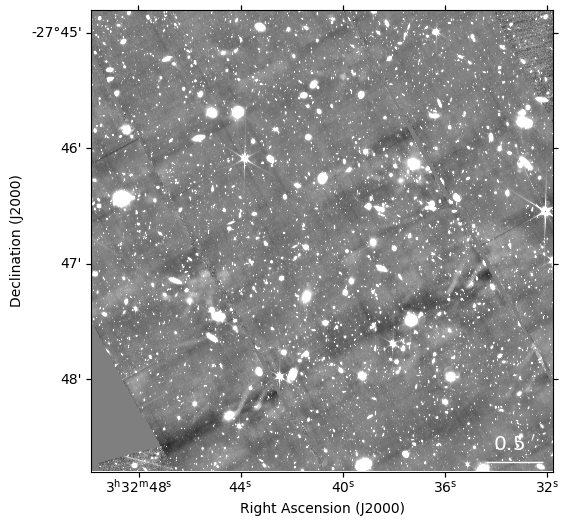

In [4]:
filename = f"/FlashStorage/image/GDS/gds-grizli-v7.2-f200w-clear_drc_sci.fits"
# filename = f"/home/ec2-user/DAWN/DJA-SEpp/image/GDS/gds-grizli-v7.2-f200w-clear_drc_sci_cutout.fits"

hdu = fits.open(filename, memmap=True)[0]
wcs = WCS(hdu.header)

center = SkyCoord('53.17 -27.78', frame='icrs', unit='deg') # GDS
# center = SkyCoord('10h00m35s 02d20m00s', frame='icrs') # COSMOS
# center = SkyCoord('14h19m45s 52d54m00s', frame='icrs') # CEERS
size=u.Quantity((4.0,4.0), u.arcmin)

cutout = Cutout2D(hdu.data, 
                  position=center, size=size, 
                  wcs=wcs,
                  mode='partial', fill_value=0.0)

fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection':cutout.wcs})
norm = ImageNormalize(cutout.data, interval=ZScaleInterval())
# norm = ImageNormalize(cutout.data, interval=MinMaxInterval(), stretch=LogStretch())
ax.imshow(cutout.data, cmap='gray', origin='lower', norm=norm)
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')
add_good_scalebar(ax, cutout.wcs)
plt.show()

## Batch cutouts

Now that we chose the framing for the cutouts, we can create cutouts for all the images we want, even with different pixel scales as the code uses the WCS.

To select the images, we use [`glob.glob`](https://docs.python.org/3/library/glob.html) which understands wildcards (*,?). We also have to specify a folder to save the cutouts in. By default, it will create a "cutout" folder inside the folder with your images.

In [3]:
def save_cutouts(generic_filename   : str, 
                 center             : Union[tuple[str],SkyCoord] , 
                 size               : Union[int,u.Quantity],
                 save_folder        : str = None, 
                 plot               : bool = False,
                 plot_str           : str = None,
                 verbose            : bool = False) -> None :
    """
    Create cutouts for all selected images, 
    centered on the same point and with the same size.

    * `generic_filename` (`str` with wildcard) : 
        Generic filename for the images to process.
        Can use wildcards (*,?) readable by `glob.glob`.
    * `center` (`tuple[str]` or `SkyCoord`) :
        Center of the cutouts.
        Can be in pixel units, or an `astropy.coordinates.SkyCoord` object (e.g. RA-DEC).
    * `size` (`int` or `Quantity`):
        Size of the cutouts.
        Can be in pixel units, or an `astropy.units.Quantity` object (e.g. angular size).
        WARNING : If pixel scale is different between images, giving a size in pixel units will result in non-aligned images.
    * `save_folder` (`str`, optional):
        Folder to save the cutouts in.
        By default, the images will be saved in a `cutout` sub_folder of the initial folder.
    * `plot` (`bool`, optional):
        Plots the cutouts with MinMax and Log stretching.
    * `plot_str` (`str`, optional):
        String to be found in image name to plot it. 
        Only active if `plot=True`. By default, all images are plotted.
    * `verbose` (`bool`, optional)
    """
    image_list = glob.glob(generic_filename)
    n = len(image_list)
    if verbose: print(f"Number of images found : {n}")
    if verbose: print(f"Images found :")
    if verbose: 
        for img in image_list: print(img)
    if plot: fig, j = plt.figure(figsize=(12,12)), 1
    for i,img in enumerate(image_list):
        print(f"Image {i+1} / {n}")
        # Load image
        hdu = fits.open(img, memmap=True)[0]
        wcs = WCS(hdu.header)
        # Cutout
        cutout = Cutout2D(hdu.data, 
                    position=center, size=size, 
                    wcs=wcs,
                    mode='partial', fill_value=0.0)
        # Save cutout
        hdu.data = cutout.data
        hdu.header.update(cutout.wcs.to_header())
        parsed_name = img.split("/")
        folder = "/".join(parsed_name[:-1])
        init_name = parsed_name[-1]
        name = f"{'.'.join(init_name.split('.')[:-1])}_cutout.fits"
        if save_folder is None: save_folder = f"{folder}/cutout"
        if not os.path.exists(save_folder): os.mkdir(save_folder) 
        hdu.writeto(f"{save_folder}/{name}", overwrite=True)
        # Plot cutout
        if plot:
            if plot_str is None or plot_str in init_name:
                ax = fig.add_subplot(max(1,int(np.sqrt(n))),max(1,int(np.sqrt(n))),j, projection=cutout.wcs)
                norm = ImageNormalize(cutout.data, interval=ZScaleInterval())
                ax.imshow(cutout.data, cmap='gray', origin='lower', norm=norm)
                ax.set_title(init_name, size='xx-small')
                ax.set_axis_off()
                j+=1
    if plot: fig.tight_layout()
    if plot: plt.show()

Number of images found : 34
Images found :
/FlashStorage/image/GDS/gds-grizli-v7.2-f115w-clear_drc_wht.fits
/FlashStorage/image/GDS/gds-grizli-v7.2-f090w-clear_drc_sci.fits
/FlashStorage/image/GDS/gds-grizli-v7.2-f356w-clear_drc_sci.fits
/FlashStorage/image/GDS/gds-grizli-v7.2-f335m-clear_drc_wht.fits
/FlashStorage/image/GDS/gds-grizli-v7.2-f182m-clear_drc_sci.fits
/FlashStorage/image/GDS/gds-grizli-v7.2-f210m-clear_drc_sci.fits
/FlashStorage/image/GDS/gds-grizli-v7.2-f210m-clear_drc_wht.fits
/FlashStorage/image/GDS/gds-grizli-v7.2-f444w-clear_drc_wht.fits
/FlashStorage/image/GDS/gds-grizli-v7.2-f460m-clear_drc_wht.fits
/FlashStorage/image/GDS/gds-grizli-v7.2-ir_drc_wht.fits
/FlashStorage/image/GDS/gds-grizli-v7.2-f200w-clear_drc_sci.fits
/FlashStorage/image/GDS/gds-grizli-v7.2-f182m-clear_drc_wht.fits
/FlashStorage/image/GDS/gds-grizli-v7.2-f480m-clear_drc_wht.fits
/FlashStorage/image/GDS/gds-grizli-v7.2-f300m-clear_drc_sci.fits
/FlashStorage/image/GDS/gds-grizli-v7.2-f300m-clear_drc_

/home/ec2-user/miniconda3/envs/dawn-310/lib/python3.10/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


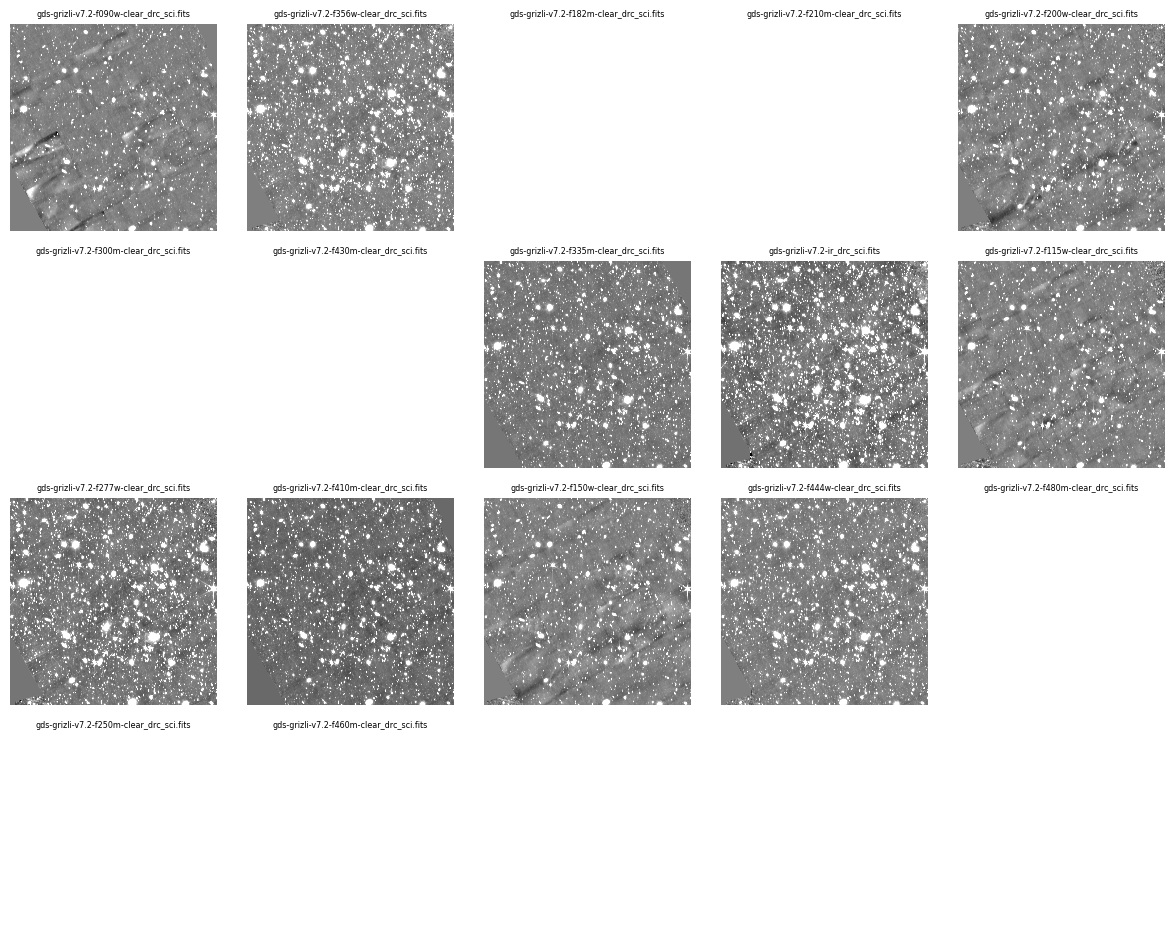

In [4]:
center = SkyCoord('53.17 -27.78', frame='icrs', unit='deg') # GDS
# center = SkyCoord('10h00m35s 02d20m00s', frame='icrs') # COSMOS
# center = SkyCoord('14h19m39s 52d54m00s', frame='icrs') # CEERS
size=u.Quantity((4.0,4.0), u.arcmin)

# save_cutouts(generic_filename="/home/ec2-user/DAWN/DJA-SEpp/image/GDS/*_cutout.fits", 
#              center=center, size=size, 
#              save_folder="/home/ec2-user/DAWN/DJA-SEpp/image/GDS",
#              plot=True, plot_str="sci", verbose=True)
save_cutouts(generic_filename="/FlashStorage/image/GDS/*.fits", 
             center=center, size=size,
             plot=True, plot_str="sci", verbose=True)